In [3]:
import sys
sys.path.append("../scripts")
from kf import *

In [13]:
def make_ax():
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("X", fontsize=10)
    ax.set_ylabel("Y", fontsize=10)
    return ax

def draw_trajectory(xs, ax):
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
def draw_observations(xs, zlist, ax):
    for s in range(len(xs)):
        if s not in zlist:
            continue
    
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi = obs[1][0], obs[1][1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x, mx], [y, my], color="pink", alpha=0.5)
        
def draw(xs, zlist):
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_trajectory(xs, ax)
    plt.show()

In [9]:
def read_data():
    hat_xs = {}
    zlist = {}
    
    with open("log.txt") as f:
        for line in f.readlines():
            tmp = line.rstrip().split()
            
            step = int(tmp[1])
            if tmp[0] == "x":
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z":
                if step not in zlist:
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[4])]).T))
                
        return hat_xs, zlist

<IPython.core.display.Javascript object>


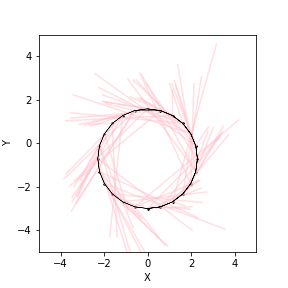

In [14]:
hat_xs, zlist = read_data()
draw(hat_xs, zlist)